In [2]:
# LIBRERIAS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# from google.colab import files
# uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

# PARAMETROS

rnd_state = 42

# TABLAS

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UTN//bikeshare.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# si es > 500 el target es 1, lo que buscamos. Para otro caso, es 0
target = np.where(df['cnt']>500, 1, 0)
target

array([0, 0, 0, ..., 0, 0, 0])

In [4]:
positivos = np.sum(target)
total = np.size(target)
print('Porcentaje de positivos: {:.2f}%'.format(100 * positivos / total))

Porcentaje de positivos: 7.36%


In [5]:
df.drop(['dteday', 'cnt'], axis=1, inplace=True)
df['target']=target

In [6]:
df.dtypes

,0
season,int64
yr,int64
mnth,int64
hr,int64
holiday,int64
weekday,int64
notbizday,int64
weathersit,int64
temp,float64
hum,float64


In [7]:
categorical_columns = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'notbizday', 'weathersit']

for col in categorical_columns:
    df[col] = df[col].astype("category")


## XGBoost

In [8]:
from xgboost import XGBClassifier

In [17]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state, stratify=y)


In [18]:
def my_XGB_report(X_train, y_train, X_test, y_test, model=None):

    # Entrenar modelo si no se pasa uno ya entrenado
    if model is None:
        model = XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            enable_categorical=True
        )
        model.fit(X_train, y_train)

    # Predicciones
    y_hat = model.predict(X_test)

    # Métricas
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test, y_hat), 4)
    error_rate = round(1 - accuracy, 4)
    precision = round(precision_score(y_test, y_hat), 2)
    recall = round(recall_score(y_test, y_hat), 2)
    f1score = round(f1_score(y_test, y_hat), 2)

    cm_labeled = pd.DataFrame(cm,
                              index=['Actual : negativos', 'Actual : positivos'],
                              columns=['Predicción : negativos', 'Predicción : positivos'])

    # Reporte
    print("-----------------------------------------")
    print("Dataset")
    print('Tamaño train: {}'.format(X_train.shape[0]))
    print('Tamaño test: {}'.format(X_test.shape[0]))
    print('Porcentaje de positivos: {:.2f}%'.format(100 * np.sum(y_train) / np.size(y_train)))
    print("-----------------------------------------")
    print("Resultados")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")

    return cm_labeled


-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9795
Error_rate  = 0.0205
Precision = 0.88
Recall    = 0.84
f1_score  = 0.86
-----------------------------------------


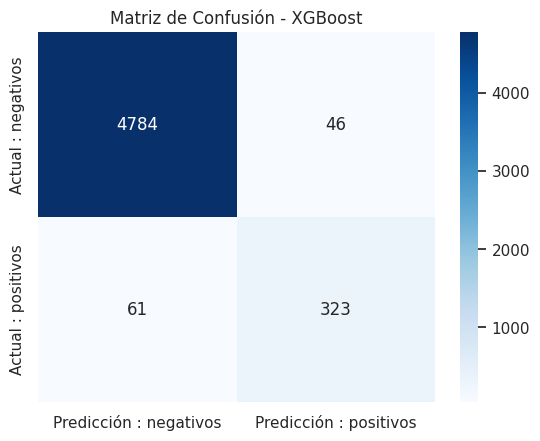

In [19]:
cm = my_XGB_report(X_train, y_train, X_test, y_test)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.title("Matriz de Confusión - XGBoost")
plt.show()

Fitting 3 folds for each of 48 candidates, totalling 144 fits
-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9795
Error_rate  = 0.0205
Precision = 0.88
Recall    = 0.84
f1_score  = 0.86
-----------------------------------------


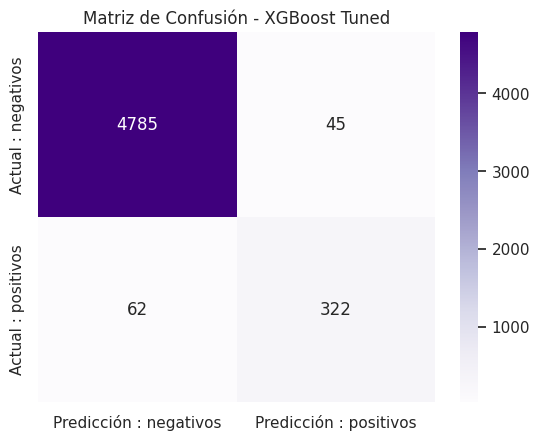

In [24]:
# Grid de hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instanciamos el clasificador base
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con los datos
grid_search_xgb.fit(X_train, y_train)

# Mejor modelo
best_xgb_model = grid_search_xgb.best_estimator_

# Reporte
cm_xgb_tuned = my_XGB_report(X_train, y_train, X_test, y_test, model=best_xgb_model)
sns.heatmap(cm_xgb_tuned, annot=True, cmap="Purples", fmt='d')
plt.title("Matriz de Confusión - XGBoost Tuned")
plt.show()

## LIGHTGBM

In [20]:
from lightgbm import LGBMClassifier

In [21]:
def my_LGBM_report(X_train, y_train, X_test, y_test, model=None):
    # Entrenar modelo si no se pasa uno ya entrenado
    if model is None:
        model = LGBMClassifier(
            random_state=42,
            verbose=-1
        )
        model.fit(X_train, y_train)

    # Predicciones
    y_hat = model.predict(X_test)

    # Métricas
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test, y_hat), 4)
    error_rate = round(1 - accuracy, 4)
    precision = round(precision_score(y_test, y_hat), 2)
    recall = round(recall_score(y_test, y_hat), 2)
    f1score = round(f1_score(y_test, y_hat), 2)

    cm_labeled = pd.DataFrame(cm,
                              index=['Actual : negativos', 'Actual : positivos'],
                              columns=['Predicción : negativos', 'Predicción : positivos'])

    # Reporte
    print("-----------------------------------------")
    print("Dataset")
    print('Tamaño train: {}'.format(X_train.shape[0]))
    print('Tamaño test: {}'.format(X_test.shape[0]))
    print('Porcentaje de positivos: {:.2f}%'.format(100 * np.sum(y_train) / np.size(y_train)))
    print("-----------------------------------------")
    print("Resultados")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")

    return cm_labeled

-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9791
Error_rate  = 0.0209
Precision = 0.87
Recall    = 0.84
f1_score  = 0.85
-----------------------------------------


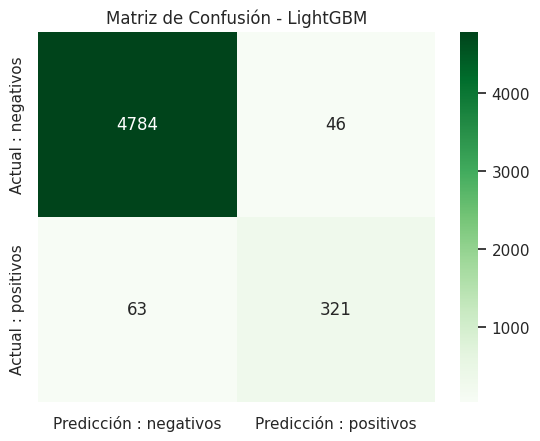

In [22]:
cm_lgbm = my_LGBM_report(X_train, y_train, X_test, y_test)
sns.heatmap(cm_lgbm, annot=True, cmap="Greens", fmt='d')
plt.title("Matriz de Confusión - LightGBM")
plt.show()

Fitting 3 folds for each of 48 candidates, totalling 144 fits
-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9806
Error_rate  = 0.0194
Precision = 0.88
Recall    = 0.86
f1_score  = 0.87
-----------------------------------------


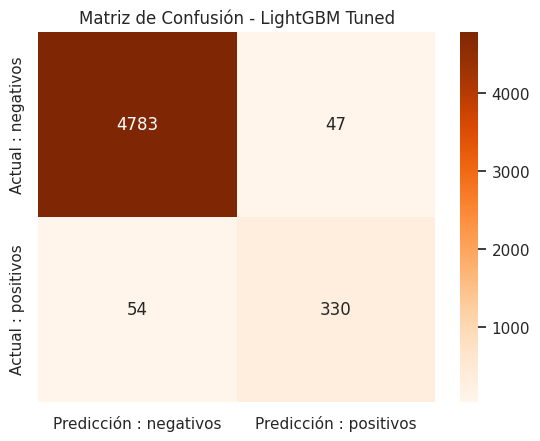

In [23]:
# Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [15, 31],
    'min_child_samples': [10, 20]
}

# Instanciamos el clasificador base
lgbm = LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Entrenamos con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Reporte con el mejor modelo
cm_lgbm_tuned = my_LGBM_report(X_train, y_train, X_test, y_test, model=best_model)
sns.heatmap(cm_lgbm_tuned, annot=True, cmap="Oranges", fmt='d')
plt.title("Matriz de Confusión - LightGBM Tuned")
plt.show()


## CATBOOST

In [26]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [27]:
from catboost import CatBoostClassifier

In [28]:
from catboost import CatBoostClassifier

def my_CatBoost_report(X_train, y_train, X_test, y_test, model=None):

    if model is None:
        model = CatBoostClassifier(
            random_seed=42,
            verbose=0,                 # Silencia la salida
            cat_features=categorical_columns
        )
        model.fit(X_train, y_train, cat_features=categorical_columns)

    # Predicción
    y_hat = model.predict(X_test)

    # Métricas
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test, y_hat), 4)
    error_rate = round(1 - accuracy, 4)
    precision = round(precision_score(y_test, y_hat), 2)
    recall = round(recall_score(y_test, y_hat), 2)
    f1score = round(f1_score(y_test, y_hat), 2)

    cm_labeled = pd.DataFrame(cm,
                              index=['Actual : negativos', 'Actual : positivos'],
                              columns=['Predicción : negativos', 'Predicción : positivos'])

    print("-----------------------------------------")
    print("Dataset")
    print('Tamaño train: {}'.format(X_train.shape[0]))
    print('Tamaño test: {}'.format(X_test.shape[0]))
    print('Porcentaje de positivos: {:.2f}%'.format(100 * np.sum(y_train) / np.size(y_train)))
    print("-----------------------------------------")
    print("Resultados")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")

    return cm_labeled


-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9766
Error_rate  = 0.0234
Precision = 0.82
Recall    = 0.88
f1_score  = 0.85
-----------------------------------------


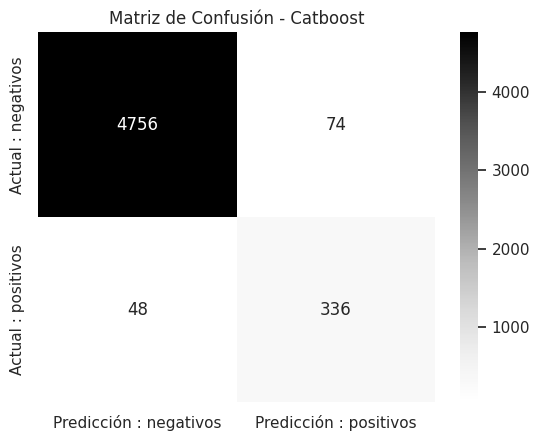

In [29]:
cm_lgbm = my_CatBoost_report(X_train, y_train, X_test, y_test)
sns.heatmap(cm_lgbm, annot=True, cmap="Grays", fmt='d')
plt.title("Matriz de Confusión - Catboost")
plt.show()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
-----------------------------------------
Dataset
Tamaño train: 12165
Tamaño test: 5214
Porcentaje de positivos: 7.36%
-----------------------------------------
Resultados
Accuracy  = 0.9779
Error_rate  = 0.0221
Precision = 0.83
Recall    = 0.88
f1_score  = 0.85
-----------------------------------------


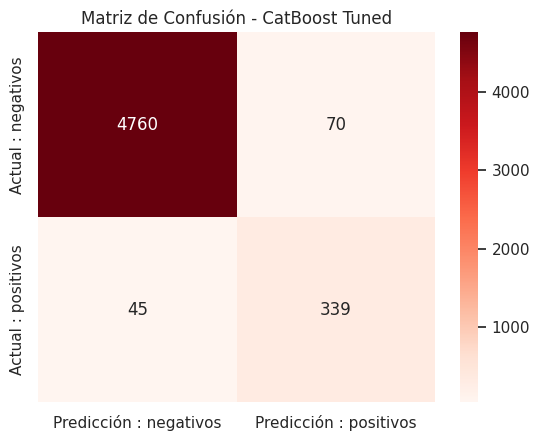

In [30]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Grid de hiperparámetros
param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Modelo base
cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=categorical_columns
)

# GridSearch
grid_search_catboost = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_catboost,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Entrenamiento
grid_search_catboost.fit(X_train, y_train)

# Mejor modelo
best_cat_model = grid_search_catboost.best_estimator_

# Reporte final
cm_catboost_tuned = my_CatBoost_report(X_train, y_train, X_test, y_test, model=best_cat_model)
sns.heatmap(cm_catboost_tuned, annot=True, cmap="Reds", fmt='d')
plt.title("Matriz de Confusión - CatBoost Tuned")
plt.show()


## COMPARATIVA FINAL

In [31]:
def get_model_metrics(y_true, y_pred, model_name):
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }


In [32]:
# Predicciones
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_lgb = best_model.predict(X_test)
y_pred_cat = best_cat_model.predict(X_test)

# Métricas
metrics_xgb = get_model_metrics(y_test, y_pred_xgb, "XGBoost")
metrics_lgb = get_model_metrics(y_test, y_pred_lgb, "LightGBM")
metrics_cat = get_model_metrics(y_test, y_pred_cat, "CatBoost")

# DataFrame con resultados
df_metrics = pd.DataFrame([metrics_xgb, metrics_lgb, metrics_cat])


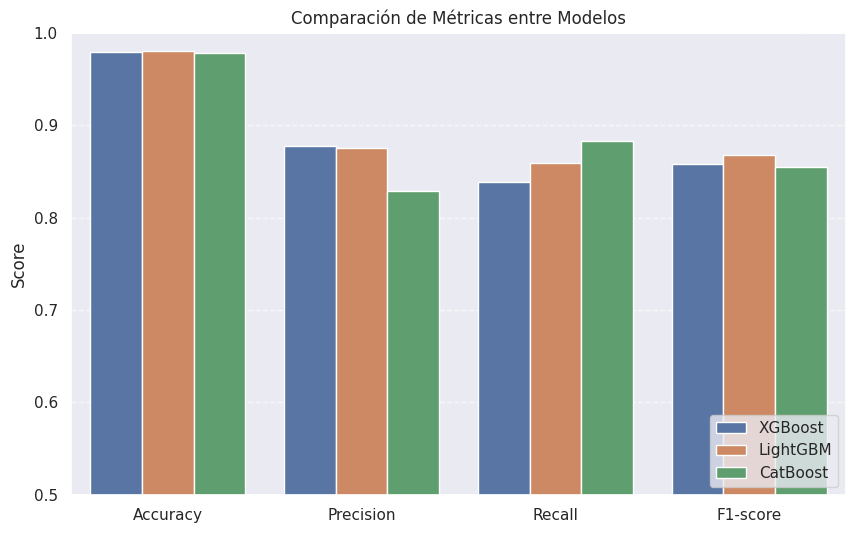

In [33]:
# Convertimos a formato largo para graficar
df_melted = df_metrics.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Métrica', y='Valor', hue='Modelo')
plt.ylim(0.5, 1)
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Score')
plt.xlabel('')
plt.legend(loc='lower right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
